In [1]:
import sys
sys.path.append('/data4/plankton_wi17/mpl/source_domain/spcbench/bench_finetune/code')
from create_dataset import PlanktonDataset
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import csv
from sklearn import metrics
%matplotlib inline

In [2]:
csv_filename = '/data4/plankton_wi17/mpl/source_domain/spcbench/bench_data/V1b/{}.csv'
img_dir = '/data5/Plankton_wi18/rawcolor_db2/images/'                         
phases = ['train', 'valid', 'test']                                           
datasets = {phase: PlanktonDataset(csv_filename = csv_filename.format(phase), 
                                   img_dir = img_dir,                         
                                   phase = phase) for phase in phases}  
# datasets['train'].data

## Dataset Visualization

### SPCBench (0:Copepod, 1:Non-Copepod)

In [12]:
df['label'].value_counts()

1    24072
0    23469
Name: label, dtype: int64

=> Class 1. Calanoida: Trained on 46 specimens -> 23469 Imgs


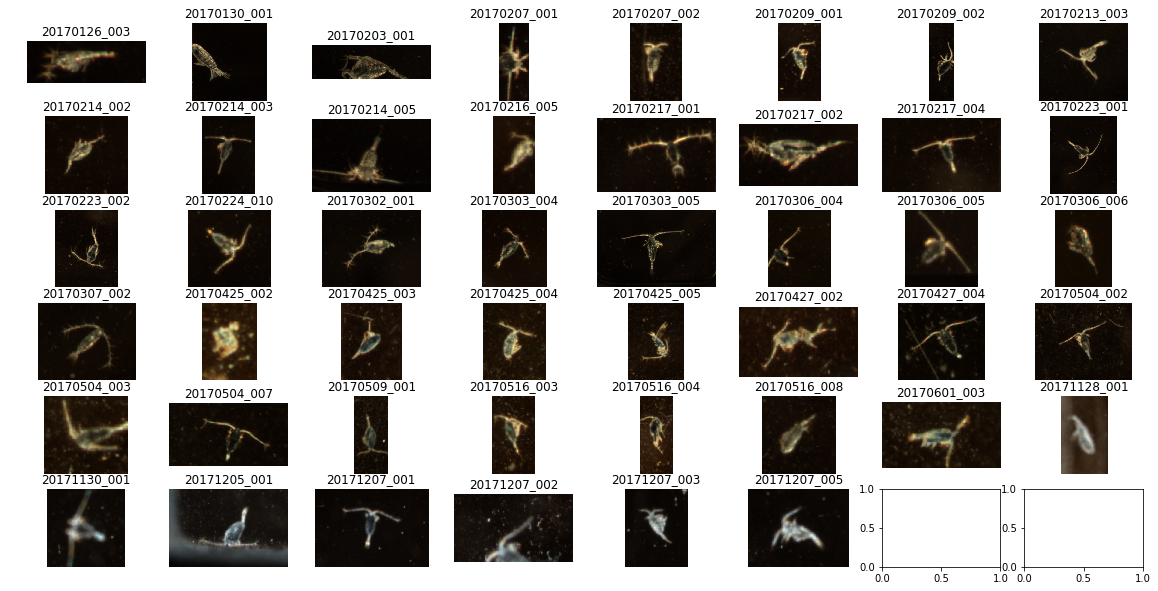

=> Class 2. Cyclopoida: Trained on 13 specimens -> 24072 Imgs


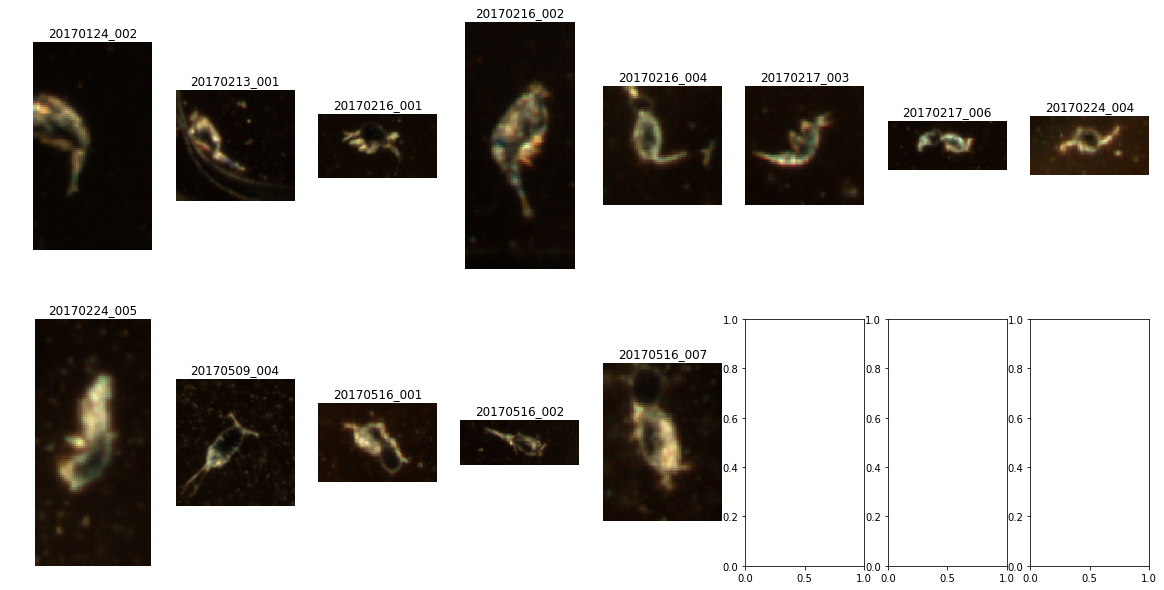

In [16]:
sortCopepod = True
if sortCopepod:
    columnToSort = 'order'
else:
    columnToSort = 'label'

df = datasets['train'].data
totalImgs = {0:df['label'].value_counts()[0], 1:df['label'].value_counts()[1]}
specimen_to_img = df['images'].groupby(df['specimen_id']).apply(list).to_dict()
classes_to_specimen = df['specimen_id'].groupby(df[columnToSort]).apply(list).to_dict()
classes_to_specimen = {classes:set(classes_to_specimen[classes]) for classes in classes_to_specimen}

if sortCopepod:
    copepodClasses = ['Calanoida', 'Cyclopoida']
    classes_to_specimen = {copepod:classes_to_specimen[copepod] for copepod in copepodClasses}

dataset = {}
for classes in classes_to_specimen:
    dataset[classes] = {spc: specimen_to_img[spc] for spc in classes_to_specimen[classes]}
    
img_dir = '/data5/Plankton_wi18/rawcolor_db2/images'
numCols = 8
for i, cls in enumerate(dataset):
#     if i==0:
#         continue
    print('=> Class {}. {}: Trained on {} specimens -> {} Imgs'.
          format(i+1, cls, len(dataset[cls]), totalImgs[i]))
    fig, axarr = plt.subplots(max(len(dataset[cls])/numCols+1,2), numCols, figsize=(20,10))
    for j,spc in enumerate(sorted(dataset[cls])):
        idx = np.random.choice(dataset[cls][spc])
        img = plt.imread(os.path.join(img_dir, idx))
        axarr[j / numCols, j % numCols].imshow(img)
        axarr[j / numCols, j % numCols].set_axis_off()
        axarr[j / numCols, j % numCols].set_title('{}'.format(spc), fontsize=12)
#         if j > 70:
#             break
    plt.show()

### SPCInsitu

In [40]:
def showImgs(dataset, numRows=10, numCols=5):
    for a, cls in enumerate(dataset):
        print 'Class {}, Total count: {} images, displaying {} random images'.format(a,len(dataset[cls]), numRows*numCols)
        fig, axarr = plt.subplots(numRows, numCols, figsize=(20, 60))
        for i in range(numRows):
            for j in range(numCols):
                img = plt.imread(np.random.choice(dataset[cls]))
                axarr[i,j].imshow(img)
                axarr[i,j].set_axis_off()
                axarr[i,j].set_title('R{} | C{}'.format(i+1,j+1), fontsize=12)
        plt.show()

Class 0, Total count: 2356 images, displaying 50 random images


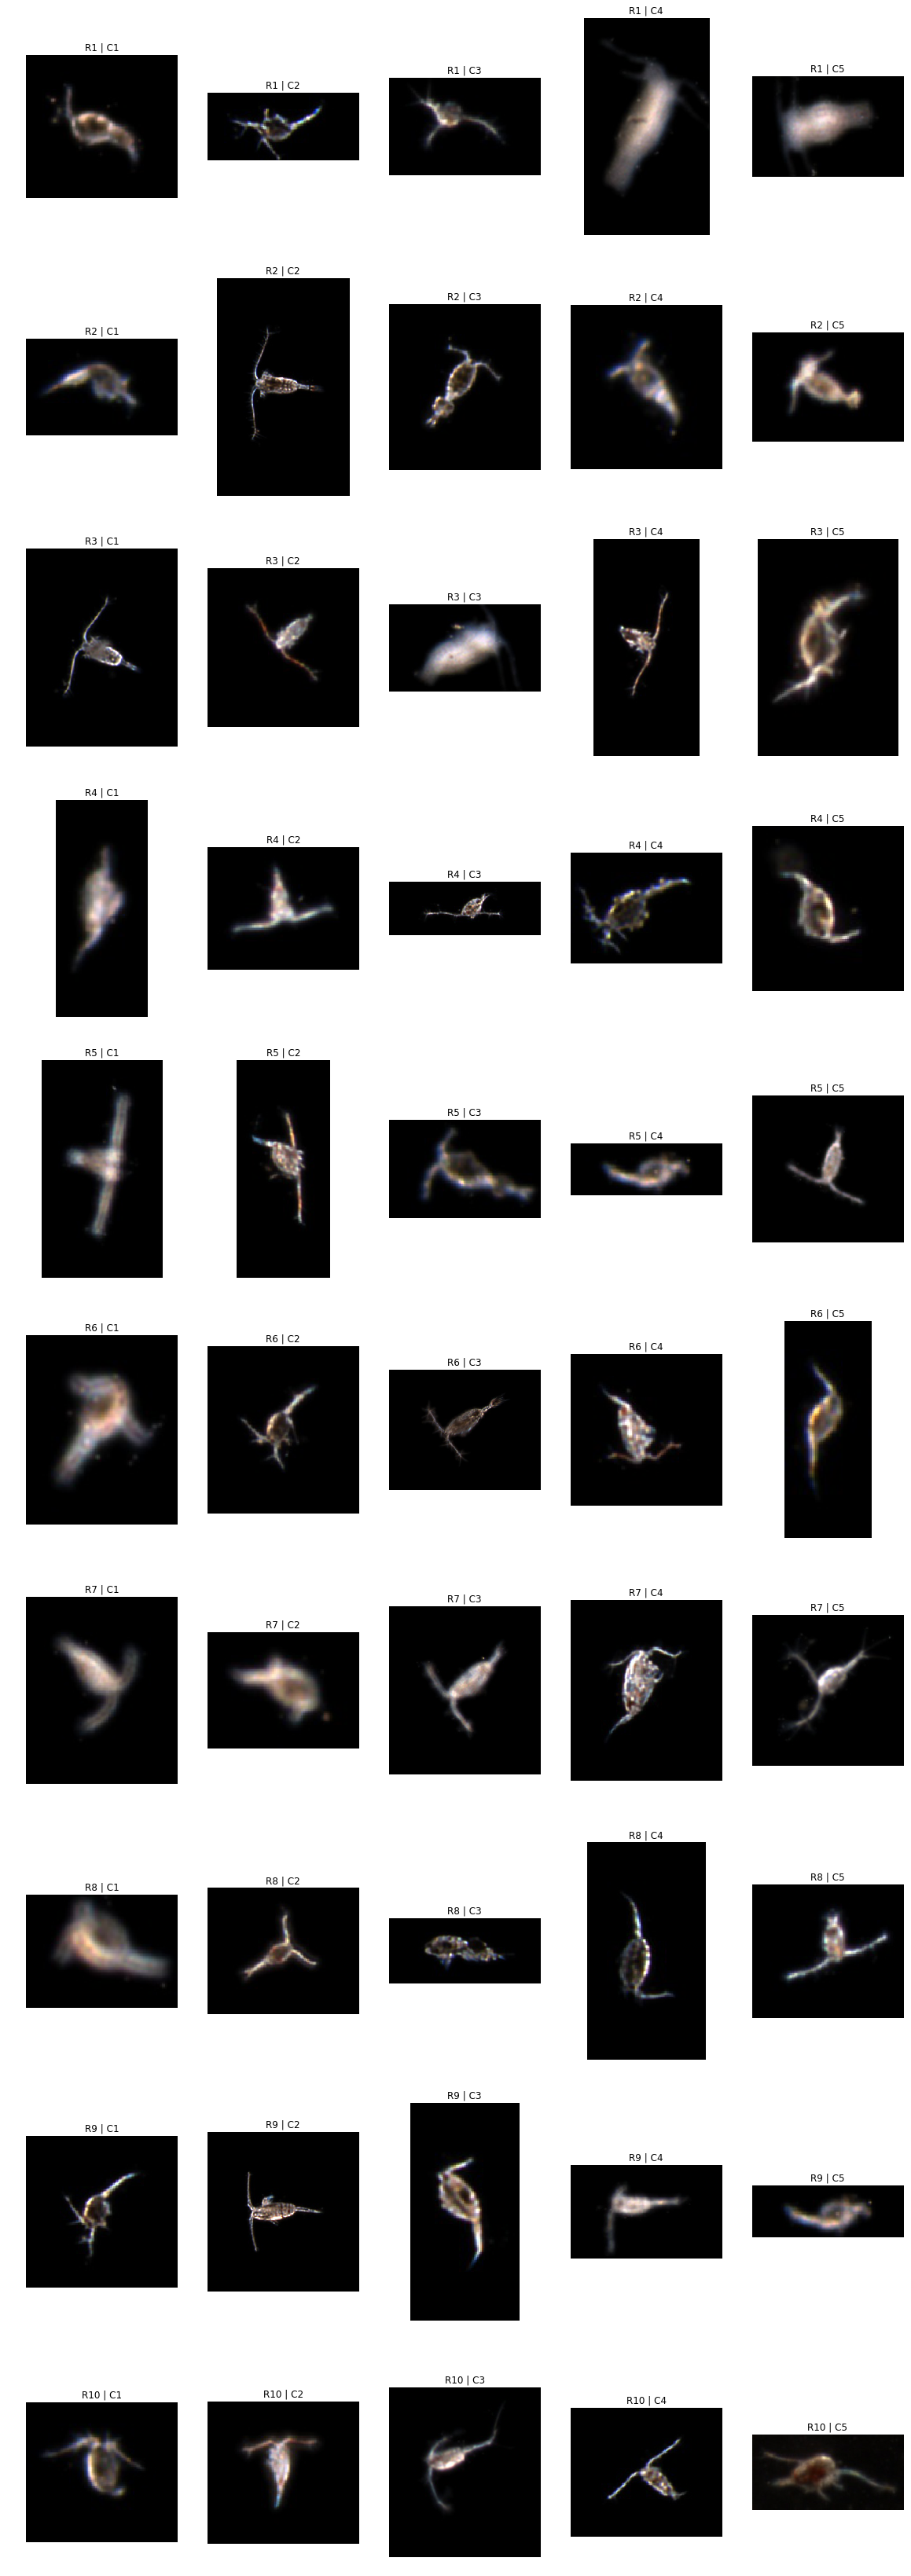

Class 1, Total count: 3404 images, displaying 50 random images


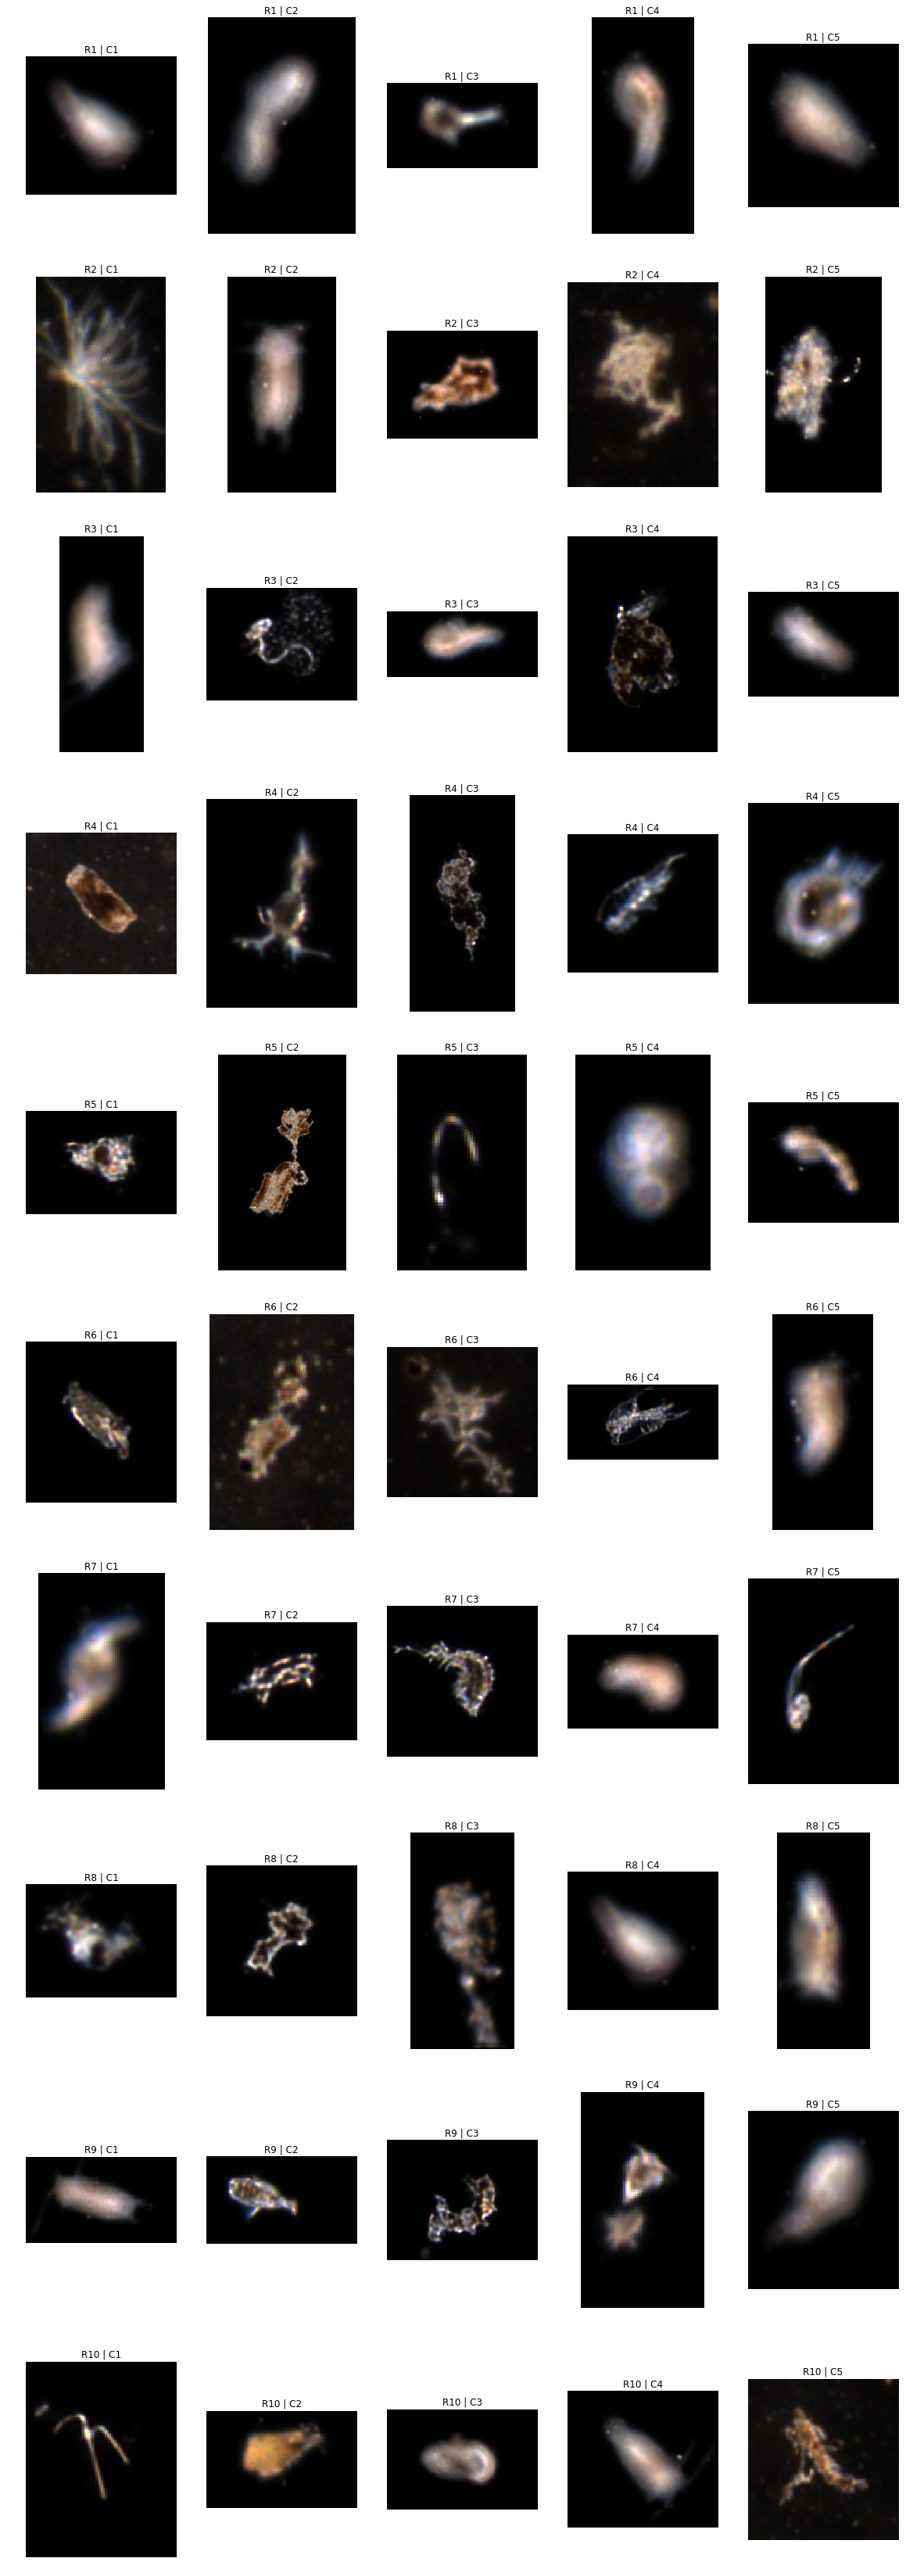

In [41]:
img_root = '/data4/plankton_wi17/mpl/source_domain/spcombo/combo_images_exp/V1b/spcinsitu'
dataset = {}
for i,cls in enumerate(sorted(os.listdir(img_root))):
    txtFileName = os.path.join(img_root, cls, 'data{}.txt'.format(i))
    dataset[i] = open(txtFileName).read().splitlines()
showImgs(dataset)

## Target Dataset Visualization

Dataset statistics
0    23049
1     2720
Name: img_label, dtype: int64
Class 0, Total count: 2720 images, displaying 50 random images


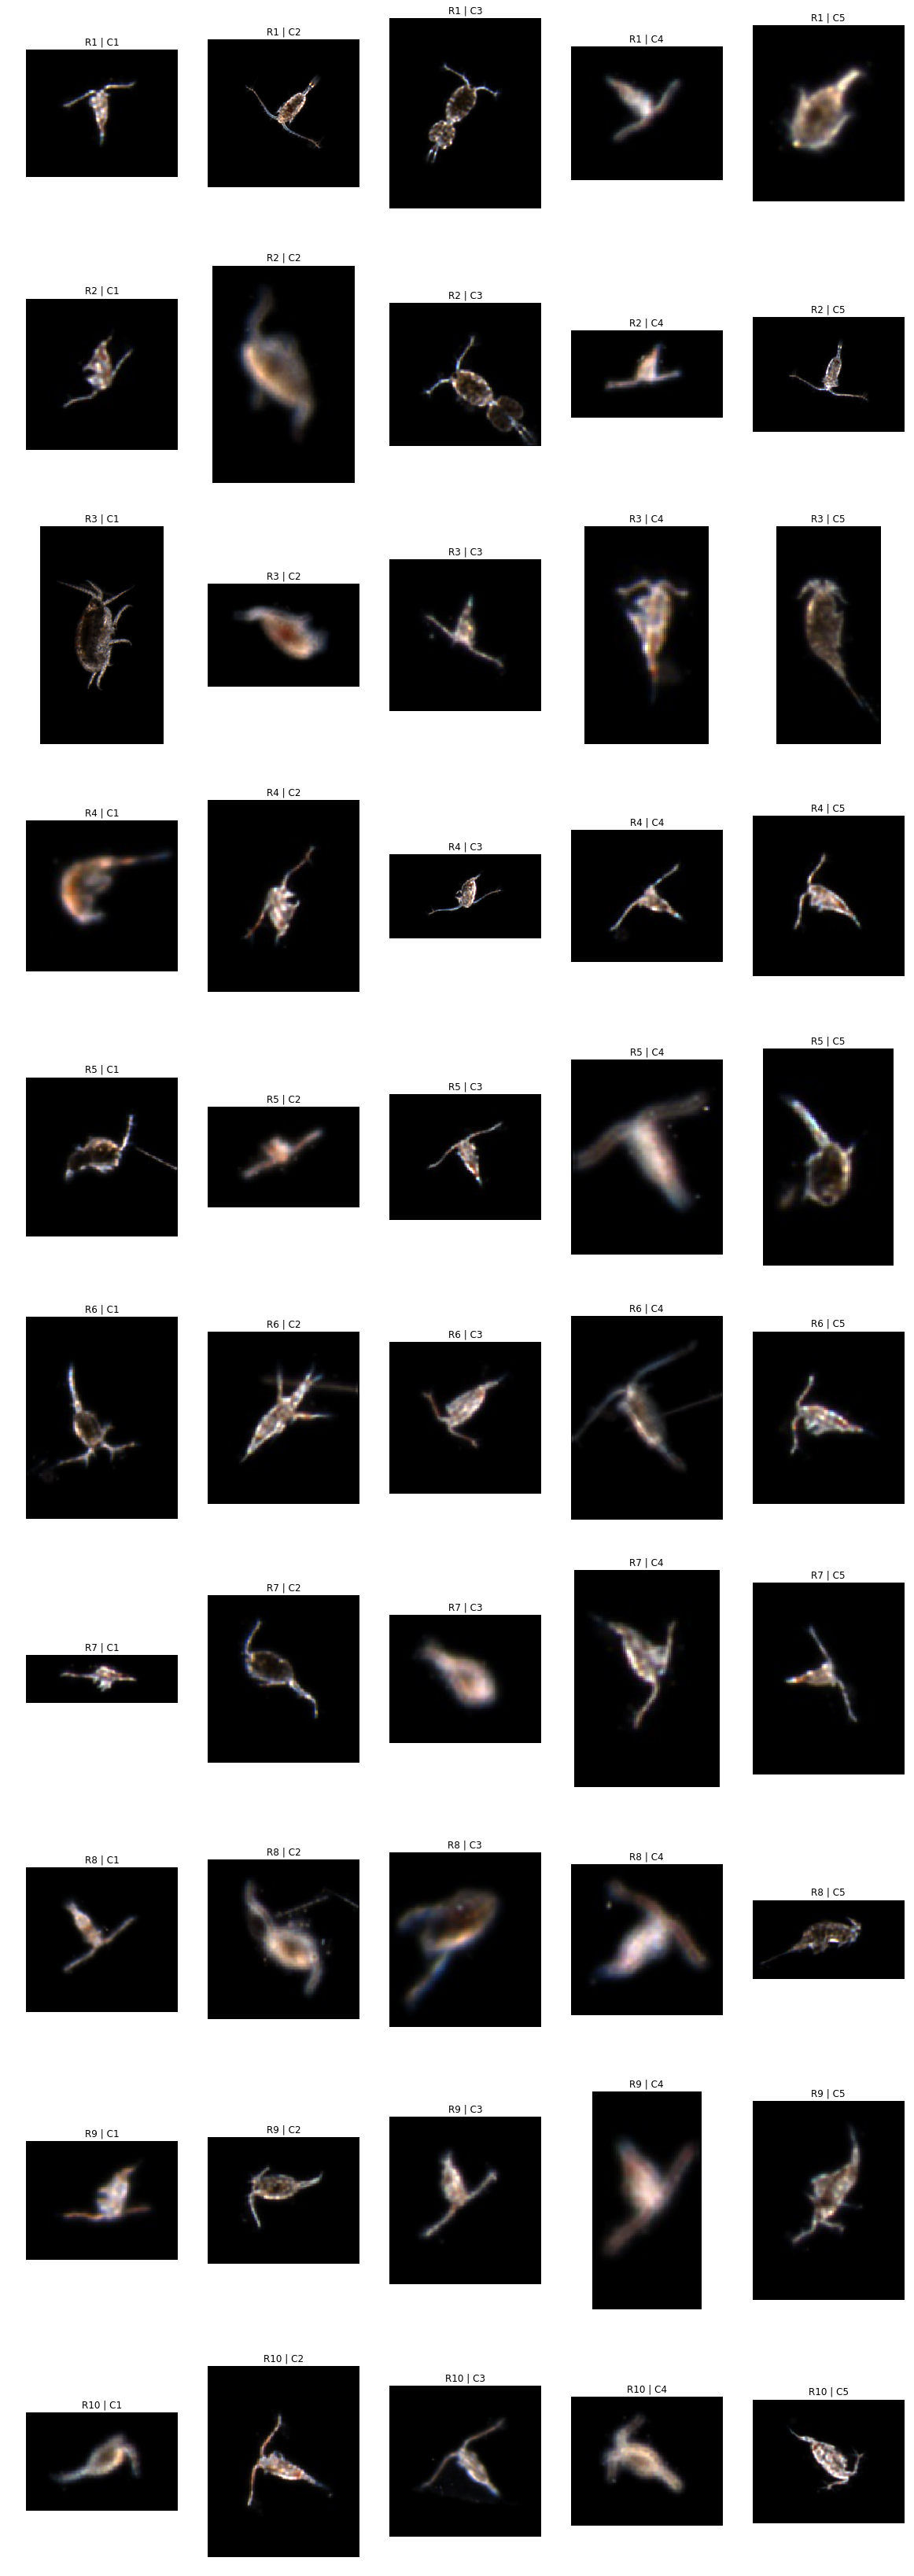

Class 1, Total count: 23049 images, displaying 50 random images


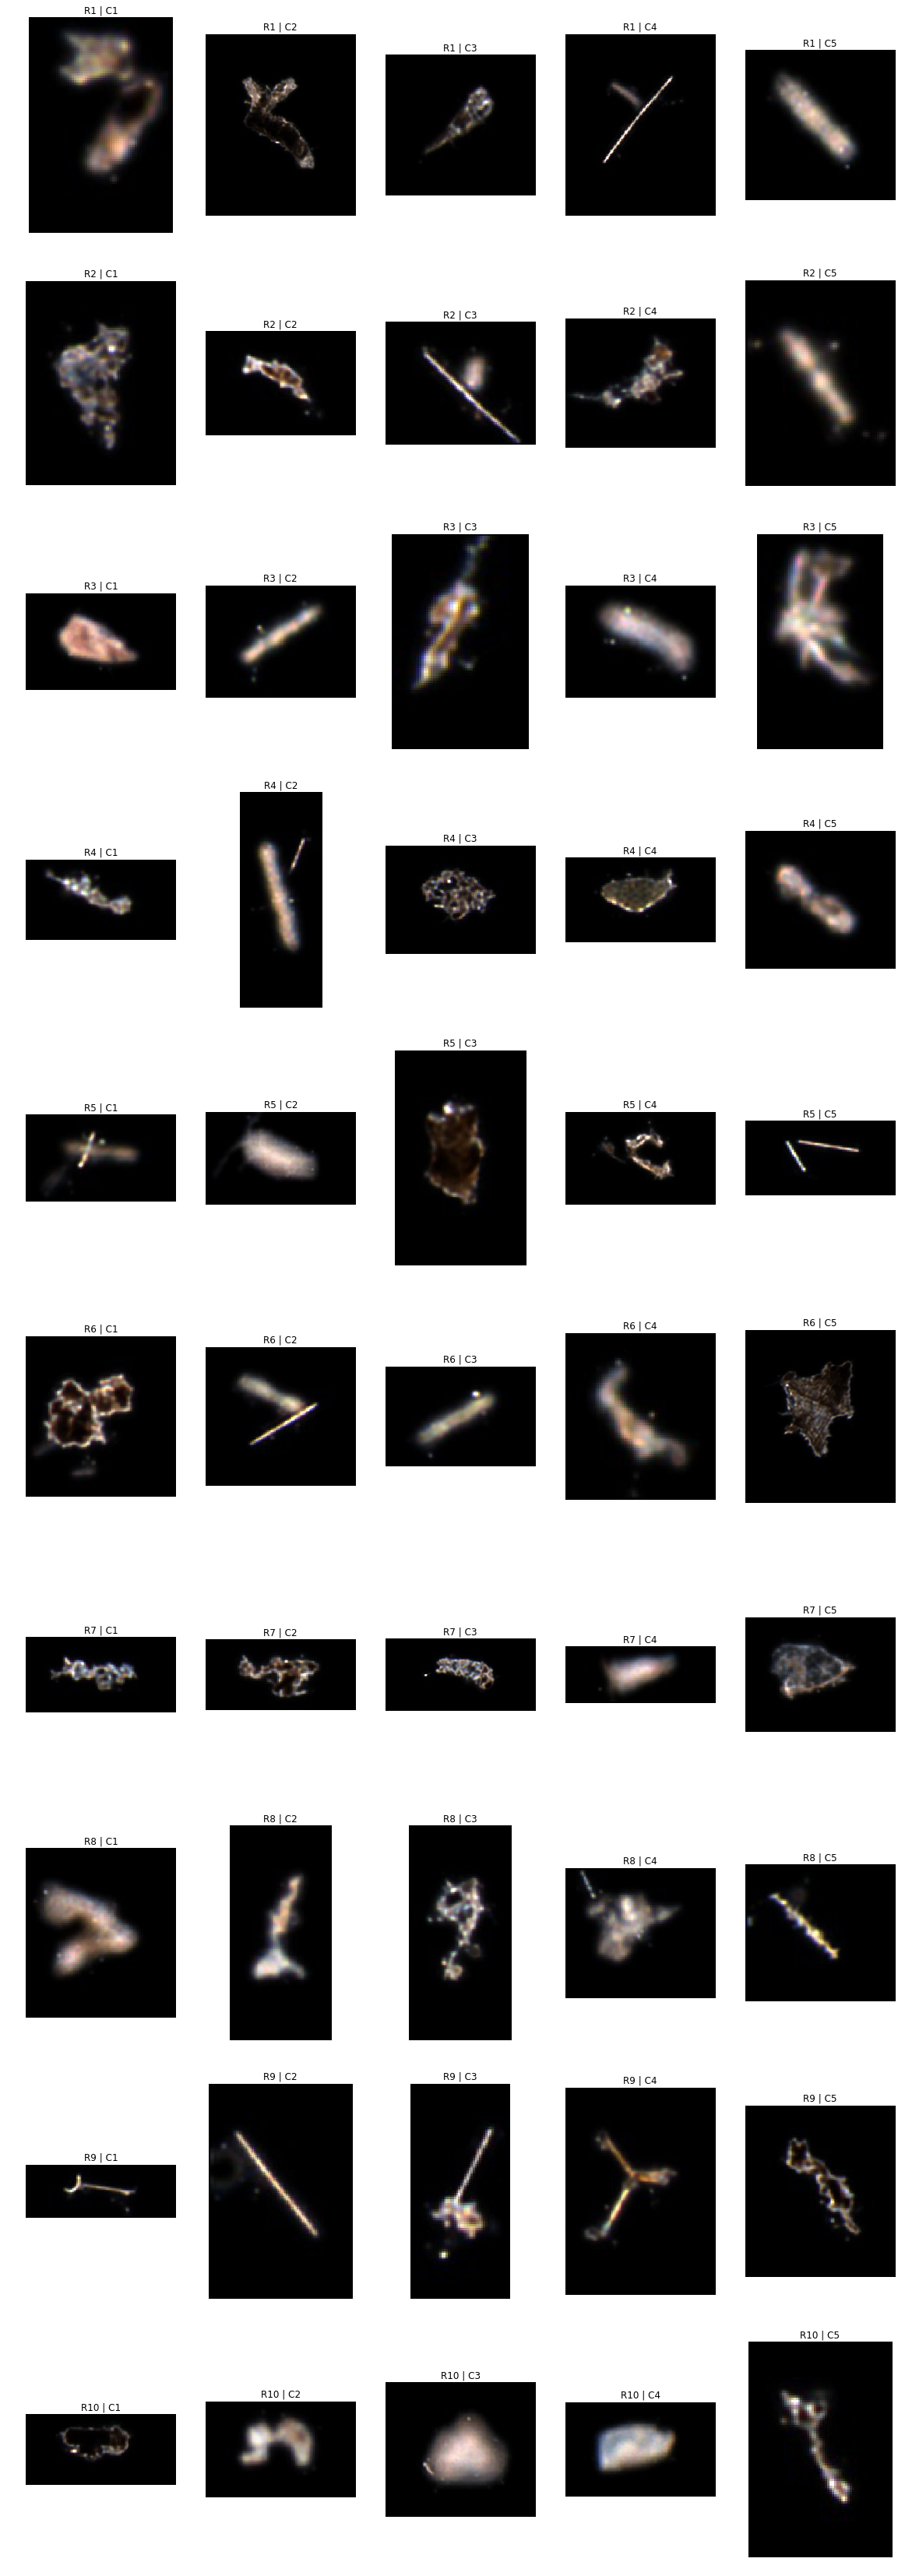

In [42]:
csvFileName = '/data4/plankton_wi17/mpl/target_domain/code_dataset_organization/ogspc-fourhr_target_image_path_labels.csv'
df = pd.read_csv(csvFileName)

# Convert categorical data to label
df['img_label']=df['img_label'].astype("category")
catColumns = df.select_dtypes(['category']).columns
df[catColumns] = df[catColumns].apply(lambda x: x.cat.codes)

# Add imgRoot
imgRoot = '/data4/plankton_wi17/mpl/target_domain/image_orig/'
df['img'] = imgRoot + df['img']

print('Dataset statistics')
print(df['img_label'].value_counts())

dataset = {0:df['img'][df['img_label'] == 1], 1:df['img'][df['img_label'] == 0]}
showImgs(dataset)

## Set root
Select the root path of the results.csv and predictions.csv file you'd like to select


In [67]:
# root = '/data4/plankton_wi17/mpl/target_domain'
# source = 'spcinsitu'
# model = 'insitu_finetune'
# exp_num='exp8'
# dataset = None

root = '/data4/plankton_wi17/mpl/target_domain'
source = 'spcombo'
model = 'combo_finetune'
dataset = 'allv1b-noise100_100-100'
exp_num = 'exp4'
if dataset is not None:
    srcpath = os.path.join(root, source, model, dataset.split('_')[0], dataset, exp_num)
else:
    srcpath = os.path.join(root, source, model, exp_num)

## View Results

In [68]:
filename = '{}-{}_Results.csv'.format(model, exp_num)
resultsfn = os.path.join(srcpath, filename)
print("Viewing results for source:{}, dataset:{}, exp:{}\n".format(source, dataset, exp_num))
with open(resultsfn, 'rb') as csvf:
    csvreader = csv.reader(csvf, delimiter=',')
    for row in csvreader:
        r = '.'.join(row)
        print r

Viewing results for source:spcombo, dataset:allv1b-noise100_100-100, exp:exp4

Binary Classifier: combo_finetune
Total Accuracy
92.21157204392874
Error Rate
7.7884279560712475
Normalized Accuracy
88.67465
Normalized Error Rate
11.32535
Precision Rate
84.19117647058823
Recall Rate
59.21903284199638
Confidence Level
84.69728231430054
Confusion Matrix (Raw Count):
2290.00.430.00
1577.00.21472.00
Confusion Matrix (Rate):
84.19.15.81
 6.84.93.16


## Visualize  Misclassified Classes

In [69]:
filename = ('Image_preds.txt' if source == 'spcbench' else '{}-{}_pred.csv'.format(model, exp_num))
predictionFile = os.path.join(srcpath, filename)
if source == 'spcbench':
    predsDF = pd.read_csv(predictionFile, sep=' ', names=['prob1', 'prob2', 'pred'])
    predsDF = predsDF.drop(columns=['prob1', 'prob2'])
predsDF = pd.read_csv(predictionFile)

if source == 'spcbench':
    gtruthFile = root + '/aspect_target_image_path_labels.txt'
    gtruthDF = pd.read_csv(gtruthFile, sep=';', names=['path', 'id', 'gtruth'])
    df = pd.concat([gtruthDF, predsDF], axis=1)
else:
    df = predsDF

In [70]:
# true_positive = df['path'][(df['gtruth'] == 0) & (df['predictions'] == 0)].tolist()
# true_negative = df['path'][(df['gtruth'] == 1) & (df['predictions'] == 1)].tolist()
# false_positive = df['path'][(df['gtruth'] == 0) & (df['predictions'] == 1)].tolist()
# false_negative = df['path'][(df['gtruth'] == 1) & (df['predictions'] == 0)].tolist()
true_positive = df[(df['gtruth'] == 0) & (df['predictions'] == 0)]
true_negative = df[(df['gtruth'] == 1) & (df['predictions'] == 1)]
false_positive = df[(df['gtruth'] == 1) & (df['predictions'] == 0)]
false_negative = df[(df['gtruth'] == 0) & (df['predictions'] == 1)]

Total count: 430 images, displaying 100 random images


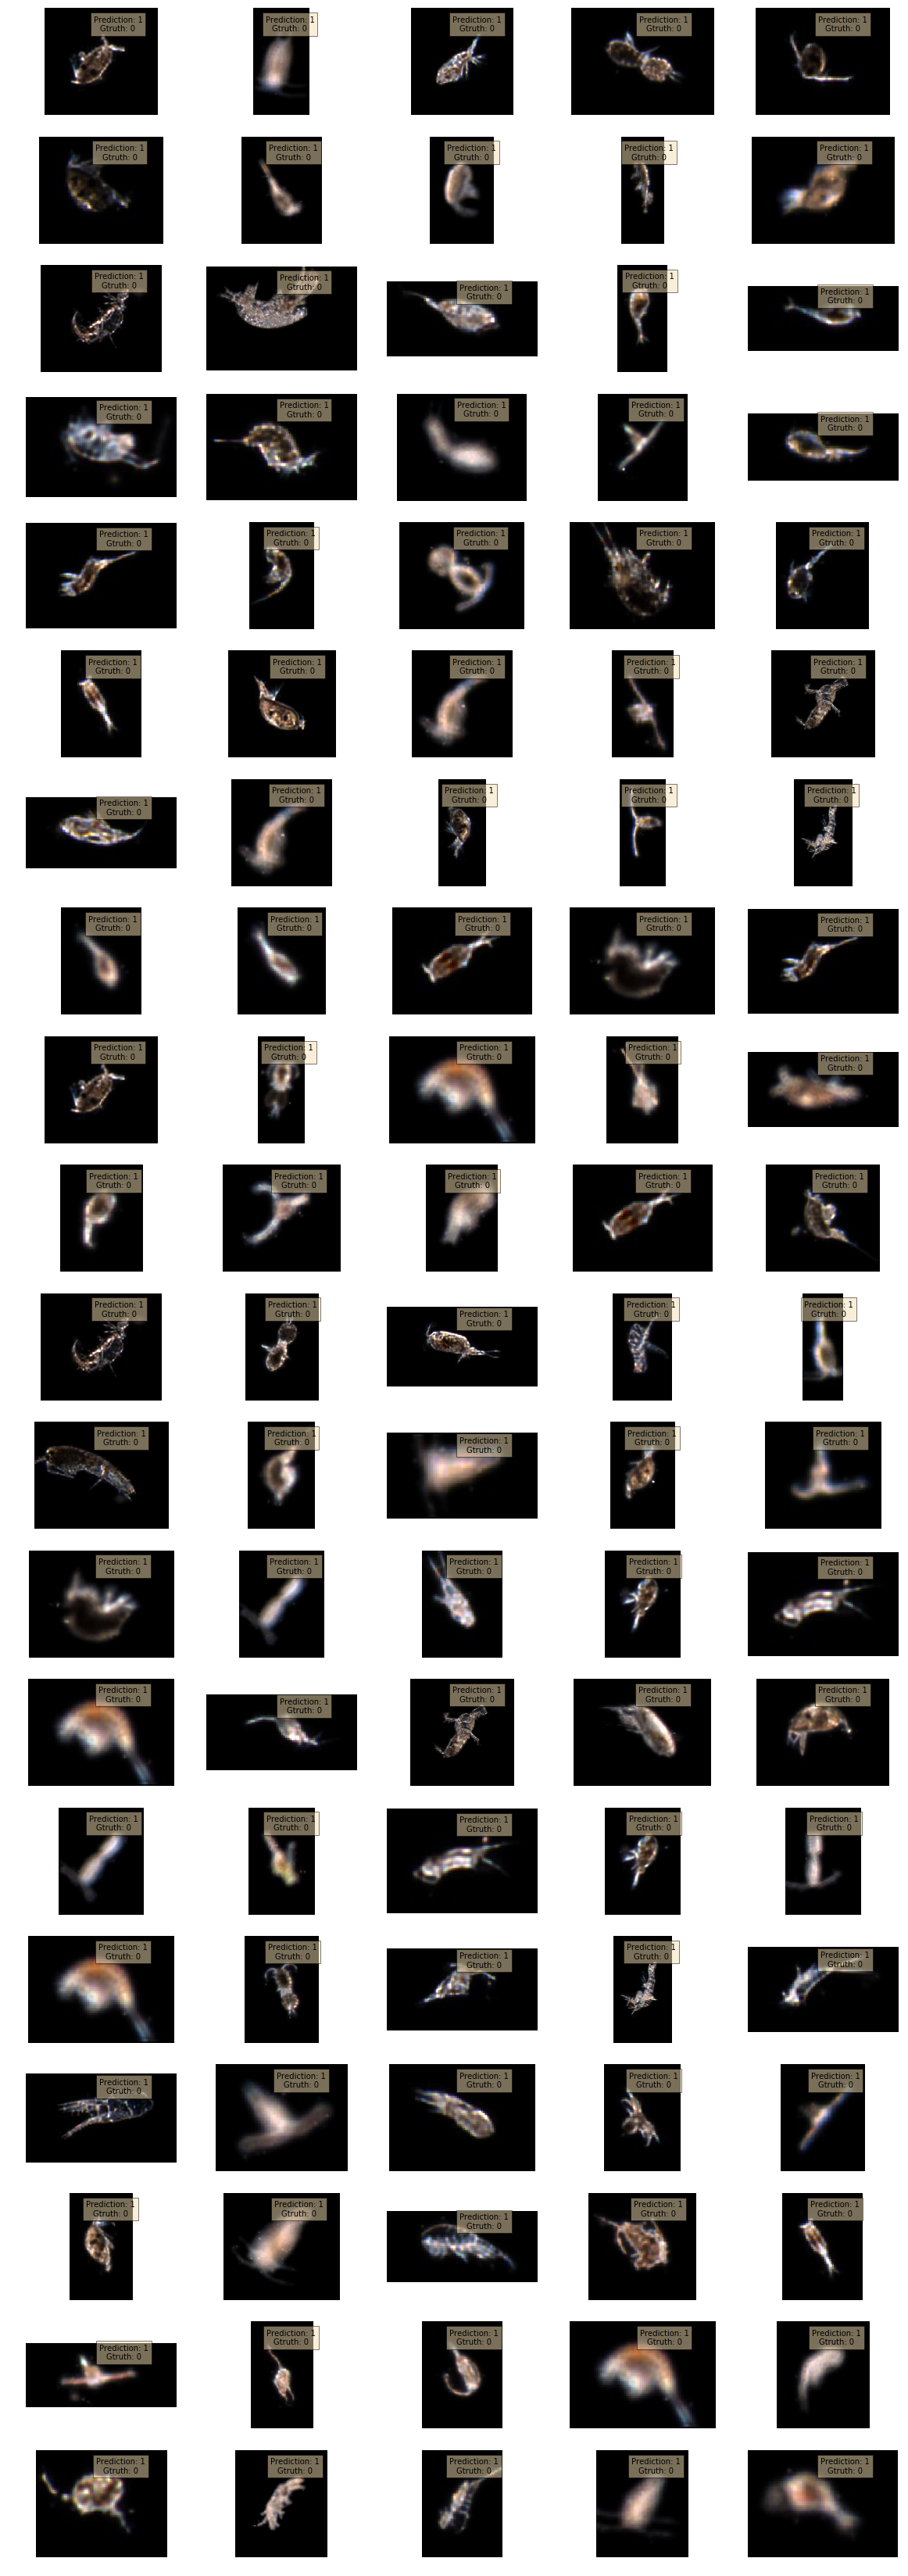

In [72]:
numRows = 20
numCols = 5
confusionDF = false_negative
gtruth, pred = 0, 1
print 'Total count: {} images, displaying {} random images'.format(len(confusionDF), numRows*numCols)
fig, axarr = plt.subplots(numRows, numCols, figsize=(20, 60))
for i in range(numRows):
    for j in range(numCols):
        randomSmpl = confusionDF.sample(n=1)
        img = plt.imread(randomSmpl['path'].values[0])
        axarr[i,j].imshow(img)
        axarr[i,j].set_axis_off()
#         axarr[i,j].set_title(randomSmpl['img_id'].values[0] if )
        axarr[i,j].text(0.65, 0.85, 'Prediction: {}\nGtruth: {}'.format(pred, gtruth), bbox=dict(facecolor='wheat', alpha=0.5),
        horizontalalignment='center', verticalalignment='center', transform=axarr[i,j].transAxes)
plt.show()

Normalized Error Rate
spcbench: 24.824%
spcinsitu: 12.311%
spcombo: 11.457%


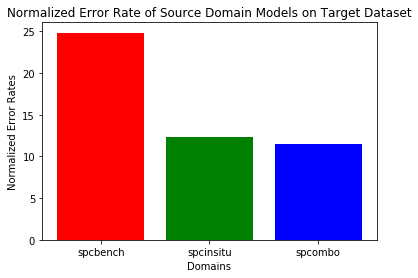

In [62]:
def generateGraphs(errorResults):
    fig, ax = plt.subplots()
    bench, insitu, combo = plt.bar(np.arange(1,4), errorResults)
    bench.set_facecolor('r')
    insitu.set_facecolor('g')
    combo.set_facecolor('b')
    ax.set_xticks(np.arange(1,4))
    ax.set_xticklabels(['spcbench','spcinsitu','spcombo'])
    ax.set_xlabel('Domains'); ax.set_ylabel('Normalized Error Rates'); ax.set_title('Normalized Error Rate of Source Domain Models on Target Dataset')
    plt.show()
    plt.savefig('PoE.png')

def getResults(domainpath, expnum):
    resultsfn = os.path.join(domainpath, expnum, '{}-{}_Results.csv'.format(domainpath.split('/')[6],expnum))
    with open(resultsfn, 'rb') as csvf:
        csvreader = csv.reader(csvf, delimiter=',')
        for row in csvreader:
            r = '.'.join(row)
            if r == 'Normalized Error Rate':
                errorRate = csvreader.next()
                return float(errorRate[0])
            
baselinePaths = {
    'spcbench':'/data4/plankton_wi17/mpl/target_domain/spcbench/bench_finetune',
    'spcinsitu':'/data4/plankton_wi17/mpl/target_domain/spcinsitu/insitu_finetune',
    'spcombo':'/data4/plankton_wi17/mpl/target_domain/spcombo/combo_finetune/allv1b-noise100/allv1b-noise100_100-100'
}
errorResults = []
errorResults.append(getResults(baselinePaths['spcbench'], 'exp5'))
errorResults.append (getResults (baselinePaths['spcinsitu'], 'exp8'))
errorResults.append (getResults (baselinePaths['spcombo'], 'exp5'))
print('Normalized Error Rate')
for i,domain in enumerate(baselinePaths):
    print('{}: {:0.3f}%'.format(domain, errorResults[i]))
generateGraphs(errorResults)

In [53]:
print(metrics.classification_report(df.gtruth, df.predictions))

             precision    recall  f1-score   support

          0       0.59      0.84      0.70      2720
          1       0.98      0.93      0.96     23049

avg / total       0.94      0.92      0.93     25769



/home/plankton/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/home/plankton/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


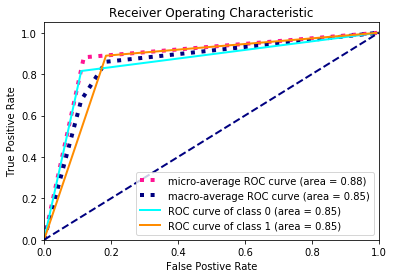

In [61]:
from sklearn import preprocessing
from scipy import interp

enc = preprocessing.OneHotEncoder()
enc.fit(df.gtruth.reshape(-1,1))
gtruth = enc.transform(df.gtruth.values.reshape(-1,1)).toarray()

enc1 = preprocessing.OneHotEncoder()
enc1.fit(df.predictions.reshape(-1,1))
predictions = enc1.transform(df.predictions.values.reshape(-1,1)).toarray()
predictions.shape
num_class = 2
for i in range(num_class):
    fpr[i],tpr[i],_ = metrics.roc_curve(gtruth[:,i],predictions[:,i])
    roc_auc[i] = metrics.auc (fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(gtruth.ravel(), predictions.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_class)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_class):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_class

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

plt.figure()
lw = 2

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua','darkorange']
for i, color in zip(range(num_class),colors):
    plt.plot(fpr[i],tpr[i],color=color,lw=lw,label='ROC curve of class {0} (area = {1:0.2f})'.format(i,roc_auc[i]))
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()